# Slow-waves detection

This notebook demonstrates how to use YASA to automatically detect slow waves on single-channel EEG.

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

## Data loading

For the example, let's load 30 seconds of N3 sleep on a single frontal EEG channel sampled at 100 Hz.

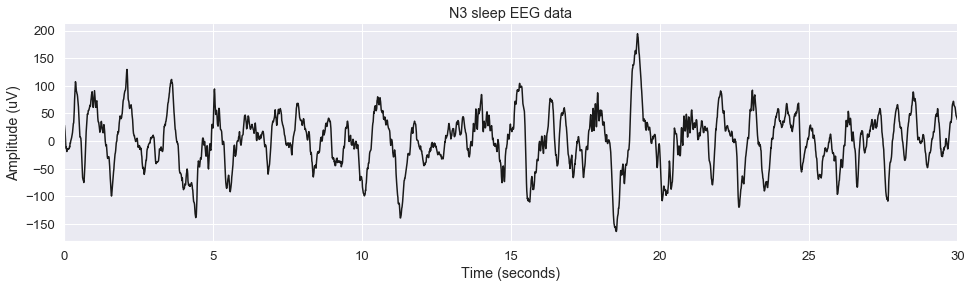

In [2]:
# Load data
data = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz').get('data')
ch_names = ['Cz', 'Fz', 'Pz']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')

# Keep only Fz and during a N3 sleep period with (huge) slow-waves
data = data[1, 669000:672000].astype(np.float64)
hypno = hypno[669000:672000]

# Define sampling frequency and time vector
sf = 100.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

## Apply the detection

We use the `sw_detect` function to apply the detection. The output is a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) where each row is a unique slow-wave and each column a parameter describing this slow-wave. The different input and output parameters are described in the documentation of the function.

In [3]:
from yasa import sw_detect

# Short version
# sw = sw_detect(data, sf, hypno=hypno)

# Long version (with all the optional arguments)
sw = sw_detect(data, sf, hypno=hypno, freq_sw=(0.3, 3.5), dur_neg=(0.3, 1.5),
               dur_pos=(0.1, 1), amp_neg=(40, 300), amp_pos=(10, 150),
               amp_ptp=(75, 400), downsample=True, remove_outliers=False)

sw.round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage
0,1.20,1.57,1.79,2.10,2.36,1.16,-99.43,89.99,189.43,861.03,0.86,3
1,5.33,5.52,5.77,6.11,6.49,1.16,-75.83,40.49,116.32,465.29,0.86,3
2,8.20,8.39,8.64,8.85,8.97,0.77,-59.41,40.39,99.80,399.22,1.30,3
3,9.84,10.05,10.26,10.53,11.05,1.21,-76.81,92.24,169.04,804.97,0.83,3
4,11.05,11.29,11.59,11.74,11.92,0.87,-115.30,45.59,160.90,536.32,1.15,3
5,14.36,14.72,14.90,15.31,15.47,1.11,-75.79,97.39,173.18,962.09,0.90,3
6,15.47,15.62,16.00,16.34,16.46,0.99,-115.33,83.63,198.97,523.60,1.01,3
7,16.90,17.06,17.23,17.95,18.29,1.39,-51.03,62.75,113.78,669.32,0.72,3
8,19.73,20.13,20.52,20.87,21.60,1.87,-96.96,31.55,128.51,329.50,0.53,3
9,22.50,22.70,22.96,23.13,23.31,0.81,-107.30,78.36,185.66,714.06,1.23,3


In [4]:
# Display the documentation of the function
sw_detect?

Signature: sw_detect(data, sf, hypno=None, freq_sw=(0.3, 3.5), dur_neg=(0.3, 1.5), dur_pos=(0.1, 1), amp_neg=(40, 300), amp_pos=(10, 150), amp_ptp=(75, 400), downsample=True, remove_outliers=False)
Docstring:
Slow-waves detection.

Parameters
----------
data : array_like
    Single-channel continuous EEG data. Unit must be uV.
sf : float
    Sampling frequency of the data in Hz.
hypno : array_like
    Sleep stage vector (hypnogram). If the hypnogram is loaded, the
    detection will only be applied to N2 and N3 sleep epochs.
    ``hypno`` MUST be a 1D array of integers with the same size as data
    and where -1 = Artefact, 0 = Wake, 1 = N1, 2 = N2, 3 = N3, 4 = REM.
    If you need help loading your hypnogram vector, please read the
    Visbrain documentation at http://visbrain.org/sleep.
freq_sw : tuple or list
    Slow wave frequency range. Default is 0.3 to 3.5 Hz. Please note that
    YASA uses a FIR filter (implemented in MNE) with a 0.2Hz transition
    band, which means that for

### Plot the detected slow-waves

In [5]:
# Let's get a bool vector indicating for each sample
bool_sw = yasa.get_bool_vector(data, sf, sw)
bool_sw

array([0, 0, 0, ..., 1, 1, 0])

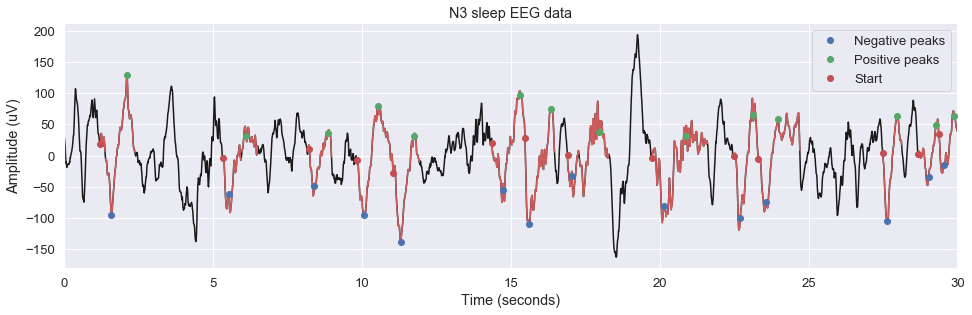

In [6]:
sw_highlight = data * bool_sw
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))
plt.plot(times, data, 'k')
plt.plot(times, sw_highlight, 'indianred')
# Note that we cannot use the ValNegPeak column since its values are computed on the filtered signal
plt.plot(sw['NegPeak'], sw_highlight[(sw['NegPeak'] * sf).astype(int)], 'bo', label='Negative peaks')
plt.plot(sw['PosPeak'], sw_highlight[(sw['PosPeak'] * sf).astype(int)], 'go', label='Positive peaks')
plt.plot(sw['Start'], data[(sw['Start'] * sf).astype(int)], 'ro', label='Start')
# plt.plot(sw['End'], data[(sw['End'] * sf).astype(int)], 'yo', label='End')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data')
plt.legend()
sns.despine()

### Computation time

In [7]:
%timeit sw_detect(data, sf)

24.2 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# Line profiling
# %load_ext line_profiler
# %lprun -f sw_detect sw_detect(data, sf)

**************************

## Step-by-step description of the algorithm

### 1. Bandpass filtering

Setting up band-pass filter from 0.3 - 3.5 Hz
Filter length of 1651 samples (16.510 sec) selected
Using filter length: 1651
Smart-padding with:  1650 samples on each edge
FFT block length:   8192


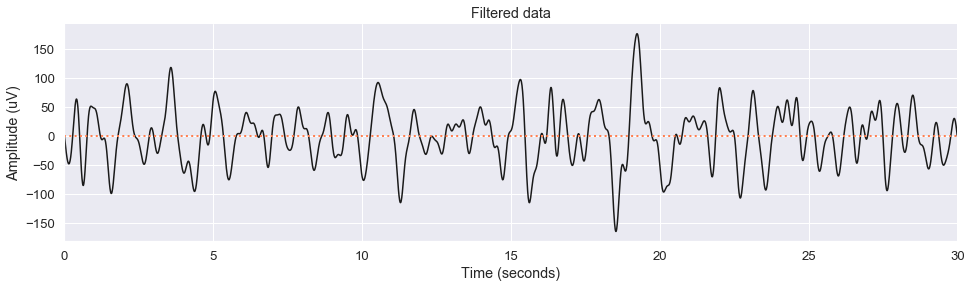

In [9]:
# Slow-waves FIR bandpass filter
freq_sw = (0.3, 3.5)
data_filt = filter_data(data, sf, freq_sw[0], freq_sw[1], method='fir', verbose=1, 
                        l_trans_bandwidth=0.2, h_trans_bandwidth=0.2)

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.axhline(0, color='coral', ls=':', lw=2)
plt.title('Filtered data')
sns.despine()

### 2. Peaks detection

In [10]:
from scipy.signal import find_peaks

# Negative peaks with value comprised between -40 to -300 uV
idx_neg_peaks, _ = find_peaks(-1 * data_filt, height=(40, 300))

# Positive peaks with values comprised between 10 to 150 uV
idx_pos_peaks, _ = find_peaks(data_filt, height=(10, 150))

display(idx_neg_peaks)
display(idx_pos_peaks)

array([  15,   63,  157,  268,  402,  437,  552,  684,  839, 1005, 1129,
       1472, 1562, 1706, 1745, 1852, 1884, 2013, 2176, 2270, 2356, 2480,
       2536, 2600, 2662, 2763, 2903, 2953], dtype=int64)

array([  40,   89,  210,  292,  358,  466,  506,  611,  634,  712,  722,
        786,  811,  885,  951,  978, 1053, 1174, 1289, 1315, 1339, 1397,
       1425, 1531, 1634, 1675, 1795, 1961, 2087, 2112, 2149, 2201, 2313,
       2396, 2428, 2459, 2509, 2638, 2681, 2712, 2738, 2797, 2850, 2928,
       2989], dtype=int64)

In [11]:
# For each negative peak, we find the closest positive peak
pk_sorted = np.searchsorted(idx_pos_peaks, idx_neg_peaks)
closest_pos_peaks = idx_pos_peaks[pk_sorted] - idx_neg_peaks
closest_pos_peaks = closest_pos_peaks[np.nonzero(closest_pos_peaks)]

idx_pos_peaks = idx_neg_peaks + closest_pos_peaks
idx_pos_peaks

array([  40,   89,  210,  292,  466,  466,  611,  712,  885, 1053, 1174,
       1531, 1634, 1795, 1795, 1961, 1961, 2087, 2201, 2313, 2396, 2509,
       2638, 2638, 2681, 2797, 2928, 2989], dtype=int64)

### 3. Amplitude and duration criteria

In [12]:
# Now we check sure that the PTP amplitude is correct
sw_ptp = np.abs(data_filt[idx_neg_peaks]) + data_filt[idx_pos_peaks]
good_ptp = np.logical_and(sw_ptp > 75, sw_ptp < 400)
display(np.round(sw_ptp))
display(good_ptp)

array([112., 137., 189.,  63.,  84., 116., 116.,  91., 100., 169., 161.,
       173., 199., 114., 106., 190.,  86., 129., 154., 186., 144.,  68.,
       111., 119.,  66., 151.,  80.,  81.])

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True])

In [13]:
# Now we need to check the negative and positive phase duration
# First let's compute the zero crossings of the filtered signal
zero_crossings = yasa.main._zerocrossings(data_filt)
zero_crossings

array([  27,   50,   76,  120,  179,  236,  284,  299,  326,  380,  458,
        474,  488,  533,  577,  649,  656,  669,  696,  739,  770,  820,
        864,  897,  939,  984, 1026, 1105, 1159, 1192, 1279, 1349, 1371,
       1436, 1490, 1547, 1600, 1607, 1619, 1646, 1662, 1690, 1723, 1730,
       1757, 1829, 1896, 1973, 2052, 2057, 2074, 2160, 2187, 2250, 2296,
       2331, 2377, 2470, 2493, 2520, 2565, 2580, 2617, 2650, 2673, 2689,
       2697, 2749, 2781, 2812, 2832, 2867, 2919, 2937, 2977, 2998],
      dtype=int64)

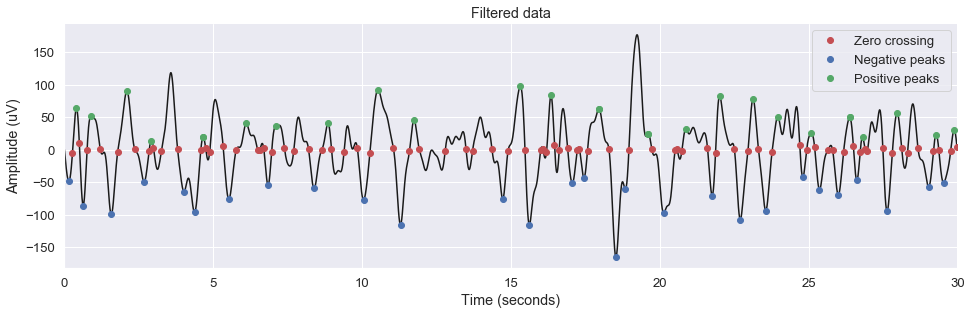

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4.5))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.plot(times[zero_crossings], data_filt[zero_crossings], 'ro', label='Zero crossing')
plt.plot(times[idx_neg_peaks], data_filt[idx_neg_peaks], 'bo', label='Negative peaks')
plt.plot(times[idx_pos_peaks], data_filt[idx_pos_peaks], 'go', label='Positive peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('Filtered data')
plt.legend()
sns.despine()

In [15]:
# Find distance to previous and following zc
neg_sorted = np.searchsorted(zero_crossings, idx_neg_peaks)
previous_neg_zc = zero_crossings[neg_sorted - 1] - idx_neg_peaks
following_neg_zc = zero_crossings[neg_sorted] - idx_neg_peaks
neg_phase_dur = (np.abs(previous_neg_zc) + following_neg_zc) / sf

neg_phase_dur

array([29.95,  0.26,  0.59,  0.48,  0.78,  0.78,  0.44,  0.27,  0.44,
        0.42,  0.54,  0.54,  0.53,  0.33,  0.27,  0.67,  0.67,  0.79,
        0.27,  0.46,  0.46,  0.23,  0.45,  0.37,  0.23,  0.32,  0.52,
        0.4 ])

In [16]:
# Find distance to previous and following zc
pos_sorted = np.searchsorted(zero_crossings, idx_pos_peaks)
previous_pos_zc = zero_crossings[pos_sorted - 1] - idx_pos_peaks
following_pos_zc = zero_crossings[pos_sorted] - idx_pos_peaks
pos_phase_dur = (np.abs(previous_pos_zc) + following_pos_zc) / sf

pos_phase_dur

array([0.23, 0.44, 0.57, 0.15, 0.16, 0.16, 0.72, 0.43, 0.33, 0.79, 0.33,
       0.57, 0.27, 0.72, 0.72, 0.77, 0.77, 0.86, 0.63, 0.35, 0.93, 0.27,
       0.33, 0.33, 0.16, 0.31, 0.18, 0.21])

In [17]:
# Define start and end
sw_start = times[idx_neg_peaks + previous_neg_zc]
sw_end = times[idx_pos_peaks + following_pos_zc]
sw_dur = sw_end - sw_start  # Same as pos_phase_dur + neg_phase_dur
sw_midcrossing = times[idx_neg_peaks + following_neg_zc]
sw_idx_neg, sw_idx_pos = times[idx_neg_peaks], times[idx_pos_peaks]
sw_slope = sw_ptp / (sw_midcrossing - sw_idx_neg)  # Slope between peak trough and midcrossing

In [18]:
# Finally we apply a set of thresholds to remove bad slow waves
good_sw = np.logical_and.reduce((previous_neg_zc != 0, 
                                 following_neg_zc != 0,
                                 previous_pos_zc != 0, 
                                 following_pos_zc != 0,
                                 neg_phase_dur > 0.125, 
                                 neg_phase_dur < 1.5,
                                 pos_phase_dur < 1, 
                                 sw_midcrossing > sw_start,
                                 sw_midcrossing < sw_end, 
                                ))
good_sw

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

### 4. Dataframe creation

In [19]:
# Create the dataframe
sw = pd.DataFrame({'Start': sw_start,
                   'NegPeak': sw_idx_neg,
                   'MidCrossing': sw_midcrossing,
                   'PosPeak': sw_idx_pos,  
                   'End': sw_end, 
                   'Duration': sw_dur,
                   'ValNegPeak': data_filt[idx_neg_peaks], 
                   'ValPosPeak': data_filt[idx_pos_peaks], 
                   'PTP': sw_ptp, 
                   'Slope': sw_slope, 
                   'Frequency': 1 / sw_dur,
                    })[good_sw]

# Remove all duplicates and reset index
sw.drop_duplicates(subset=['Start'], inplace=True, keep=False)
sw.drop_duplicates(subset=['End'], inplace=True, keep=False)
sw.reset_index(drop=True, inplace=True)
sw.round(3)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
0,0.50,0.63,0.76,0.89,1.20,0.70,-85.682,51.309,136.991,1053.781,1.429
1,1.20,1.57,1.79,2.10,2.36,1.16,-99.435,89.993,189.427,861.033,0.862
2,2.36,2.68,2.84,2.92,2.99,0.63,-49.028,13.962,62.991,393.693,1.587
3,5.33,5.52,5.77,6.11,6.49,1.16,-75.829,40.493,116.322,465.288,0.862
4,6.69,6.84,6.96,7.12,7.39,0.70,-54.510,36.101,90.610,755.085,1.429
5,8.20,8.39,8.64,8.85,8.97,0.77,-59.413,40.391,99.805,399.218,1.299
6,9.84,10.05,10.26,10.53,11.05,1.21,-76.805,92.238,169.043,804.968,0.826
7,11.05,11.29,11.59,11.74,11.92,0.87,-115.304,45.594,160.897,536.325,1.149
8,14.36,14.72,14.90,15.31,15.47,1.11,-75.789,97.387,173.176,962.090,0.901
9,15.47,15.62,16.00,16.34,16.46,0.99,-115.333,83.634,198.967,523.596,1.010


**********************

### Bonus: compute the pointwise delta power

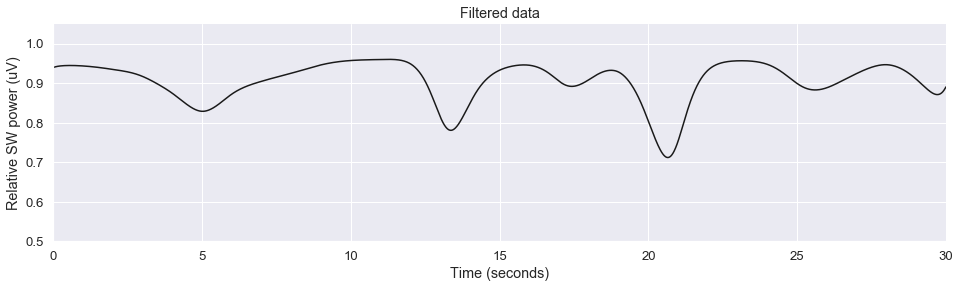

In [25]:
from scipy.interpolate import interp1d

# Compute the pointwise relative power using interpolated STFT
# Here we use a step of 1000 ms to speed up the computation.
f, t, Sxx = yasa.main.stft_power(data, sf, window=5, step=1, interp=True, norm=True)
idx_sw = np.logical_and(f >= 0.5, f <= 3.5)
sw_rel_pow = Sxx[idx_sw].sum(0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, sw_rel_pow, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Relative SW power (uV)')
plt.xlim([times.min(), times.max()])
plt.ylim(0.5, 1.05)
plt.title('Filtered data')
sns.despine()